# Optimización de las transiciones de una red de Damman con PySwarms

**Autor**: Ángela Soria García + Luis Miguel Sánchez Brea

**Fecha**: 11/10/2021

**Objetivo**: Desarrollar un procedimiento de optimización para las transiciones de una red de Damman.

**Descripción**: Implementamos una función que calcule las eficiencias del órdenes de difracción de la red de Damman. Las expresiones utilizadas son las dadas en el Optixplorer_Manual_v2.8d (pág 29). Con la librería PySwarms optimizamos estas transiciones para que la energía de todos los órdenes sea igual.

Voy a intentar dividir la función de ejecución de la función de mérito

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import pyswarms as ps
from pyswarms.utils.functions import single_obj as fx
from pyswarms.single.global_best import GlobalBestPSO
from pyswarms.single.local_best import LocalBestPSO
from pyswarms.utils.plotters import (plot_cost_history, plot_contour, plot_surface)
from pyswarms.utils.plotters.formatters import Mesher

## Eficiencias

In [3]:
def Dammann_efficiencies(orders, transitions, phase_shift=np.pi, has_draw=False):
    """ Compute de efficiency of a Dammann Grating
    
    Arguments:
        orders (np.array): diffraction orders to evaluation
        transitions (np.array): position of the transitions. Transitions are in the (0,1) range (period is normalized to 1)
    
    Returns:
        efficiencies (np.array): efficiencies of the Dammann grating for the orders and transitions
    
    Reference: 
        Optixplorer_Manual_v2.8d (pág 29)
    
    TODO:
        Remove for loops
    
    """
    
 
    efficiencies = np.zeros_like(orders, dtype=float)
    
    for i, l in enumerate(orders):

            S, C, Q = 0, 0, 0

            for k, xk in enumerate(transitions):

                S = S + (-1)**(k+1) * np.sin(2*np.pi*l * xk)
                C = C + (-1)**(k+1) * np.cos(2*np.pi*l * xk)
                Q = Q + (-1)**(k+1) * (xk)

            if l==0:
                ef = 1 - 4*Q*(1-Q)*np.sin(phase_shift/2)**2

            else: 
                ef = np.sin(phase_shift/2)**2/(phase_shift*l)**2 * (C**2 + S**2)

            efficiencies[i] = ef
            
    if has_draw:
        orders_draw=np.concatenate((-np.flipud(orders), orders))
        efficiencies_draw=np.concatenate((np.flipud(efficiencies), efficiencies))
        plt.figure(figsize=(14,8))
        plt.plot(orders_draw,efficiencies_draw ,'rs',ms=8)
        plt.xlabel('Diffration orders');
        plt.ylabel('Intensities')
        plt.ylim(0, efficiencies_draw.max()*1.1)
        
    return efficiencies

In [4]:
def Dammann_efficiencies_N(orders, transitions, phase_shift=np.pi):
    """ Compute de efficiency of a Dammann Grating

    Arguments:
        orders (np.array): diffraction orders to evaluation
        transitions (np.array): position of the transitions. Transitions are in the (0,1) range (period is normalized to 1)

    Returns:
        efficiencies (np.array): efficiencies of the Dammann grating for the orders and transitions

    Reference: 
        Optixplorer_Manual_v2.8d (pág 29)

    TODO:
        Remove for loops

    """
    # def Dammann_efficiencies_N(x,number_transitions,num_orders,n_particles):
    """""
    x: np.array a
    number_transitons: int
    num_orders: int

    """""

    transitions.sort()
    num_particles, num_transitions = transitions.shape
    num_orders = orders.shape[0]
    efficiencies = np.zeros((num_particles,num_orders))


    #ef_max = np.zeros(n_particles)
    #ef_min = np.ones(n_particles)*(1/len(orders))

    sumatorio = 0

    for i, l in enumerate(orders):

        S, C, Q = 0, 0, 0

        for k in range(num_transitions):

            S = S + (-1)**(k+1) * np.sin(2*np.pi*l * transitions[:,k])
            C = C + (-1)**(k+1) * np.cos(2*np.pi*l * transitions[:,k])
            Q = Q + (-1)**(k+1) * (transitions[:,k])

        if l==0:
            ef = 1 - 4*Q*(1-Q)*np.sin(phase_shift/2)**2
            #print('EF_0',ef)

        else: 
            ef = np.sin(phase_shift/2)**2/(phase_shift*l)**2 * (C**2 + S**2)

        efficiencies[:,i] = ef
    
    return efficiencies

## Funciones de coste

In [5]:
def cost_Dammann1(efficiencies_real, efficiencies_objective, normalize=True):
    """Evaluates the distance between the efficiencies given by transitions and desired efficiencies
    
    Arguments:
        efficiencies (np.array): efficiencies given by Dammann algorithm
        efficiencies_objective (np.array): desired efficiencies
        normalize (bool): If True, a normalization in the effficiencies is provided
        
    Returns:
        cost (float): cost function
    
    """
    
    if normalize is False:
        mnse = np.sqrt(((efficiencies_real-efficiencies_objective)**2).sum())
    else:
        eff_real = efficiencies_real/efficiencies_real.sum()
        eff_obj  = efficiencies_objective/efficiencies_objective.sum()
        mnse = np.sqrt(((eff_real-eff_obj)**2).sum())

    return mnse

In [6]:
def cost_Dammann(efficiencies_real, efficiencies_objective, normalize=False):
    """Evaluates the distance between the efficiencies given by transitions and desired efficiencies
    
    Arguments:
        efficiencies (np.array): efficiencies given by Dammann algorithm
        efficiencies_objective (np.array): desired efficiencies
        normalize (bool): If True, a normalization in the effficiencies is provided
        
    Returns:
        cost (float): cost function
    
    """
    
    if normalize is False:
        mnse = np.sqrt(((efficiencies_real-efficiencies_objective)**2).mean(axis=1))
    else:
        suma_real = efficiencies_real.mean(axis=0)
        suma_obj  = efficiencies_objective.mean()
        mnse = np.sqrt(((efficiencies_real/suma_real-efficiencies_objective/suma_obj)**2).mean(axis=1))

    return mnse

El número de dimensiones del problema corresponde con el número de transiciones de la red de Damman. El número de órdenes corresponde con los órdenes de difracción de la red.

## Optimization

In [7]:
def optimize_Dammann(transitions, orders, effs_desired, phase_shift=np.pi/2):

    eff1 = Dammann_efficiencies_N(orders, transitions, phase_shift)
    cost1 = cost_Dammann(eff1, effs_desired, normalize=False)
    return cost1

## Create desired efficiencies

In [8]:
def generate_desired_efficiencies(kind, num_orders, num_zeros=0, has_draw=True):
    """Generate desired efficiencies
    """

    orders = np.arange(0,num_orders+num_zeros)
    effs_desired=np.zeros_like(orders, dtype=float)
    if kind=='equal':
        effs_desired[0:num_orders] = 1./(2*num_orders+1.)
    elif kind=='triangle':
        effs_desired[0:num_orders]=(num_orders-orders[0:num_orders]-1)
        effs_desired=effs_desired/(2*effs_desired.sum()-effs_desired[0])
        print(effs_desired)
    elif kind=='alternated':
        effs_desired[0:num_orders:2]=1
        effs_desired=effs_desired/effs_desired.sum()

    if has_draw:
        plt.plot(orders, effs_desired,'ko')
        plt.ylim(0,effs_desired.max()*1.1)
        
    return orders, effs_desired

## Ejemplos

### Ejemplo óptimo

In [9]:
transitions_optimal=np.array([0, 0.201181, 0.250978, 0.326167,  0.370555,  0.372996,  0.396478,  0.453128,  0.594731, 0.670591, 0.717718,  0.890632, 0.919921, 0.935546])
orders_optimal = np.arange(0,21)
effs_desired_optimal=1/19*np.ones_like(orders_optimal)
eff_optimal = Dammann_efficiencies(orders_optimal, transitions_optimal, phase_shift=np.pi, has_draw=True)

In [10]:
eff_total=eff_optimal.sum()
print("efficiencia total = {:2.2f} %".format(eff_total*100))

efficiencia total = 44.88 %


In [11]:
cost1=cost_Dammann1(eff_total, effs_desired_optimal, normalize=False)
print(cost1)

1.815516515629943


### Ejemplo eficiencias

In [12]:
num_orders = 3
num_transitions = 6

orders = np.arange(0,num_orders+1)
transitions=np.random.rand(num_transitions)


In [13]:
eff1 = Dammann_efficiencies(orders, transitions, phase_shift=np.pi, has_draw=True)

### Ejemplo ordenes desedados

In [14]:
num_orders=5
num_zeros=5
orders, effs_desired=generate_desired_efficiencies(kind='triangle', num_orders=num_orders, num_zeros=num_zeros, has_draw=True)

[0.25   0.1875 0.125  0.0625 0.     0.     0.     0.     0.     0.    ]


## Example of algorithm

Utilizamos la función GlobalBestPSO de PySwarms para optimizar la función, cuyos argumentos son los siguientes:

- n_particles: # de partículas que el algoritmo utiliza para alcanzar el mínimo.
- dimensions: Las dimensiones corresponde con las trasiciones de nuestra red.
- options: 
   * c1 : float
      cognitive parameter
   * c2 : float
        social parameter
   * w : float
        inertia parameter 
- bounds: Restricciones mínima y máxima de las transiciones de la red



In [15]:
num_orders = 6
num_zeros=2
num_transitions = 8 # siempe par
num_iters=1250 # suelen ser más
num_particles = 50 # suelen ser más

[0.2  0.16 0.12 0.08 0.04 0.   0.   0.  ]


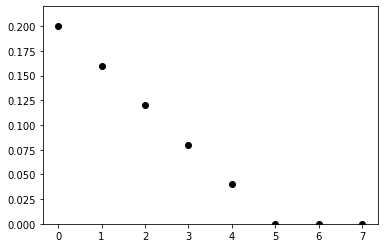

In [16]:
'equal', 'triangle', 'alternated'
orders, effs_desired=generate_desired_efficiencies(kind='triangle', num_orders=num_orders, num_zeros=num_zeros, has_draw=True)

In [17]:
min_bound = np.zeros(num_transitions)
max_bound = np.ones(num_transitions)
bounds = (min_bound, max_bound)

In [18]:
%%time

options = {'c1': 0.5, 'c2': 0.6, 'w': 0.9}

optimizer = GlobalBestPSO(n_particles=num_particles, dimensions=num_transitions, options=options, bounds=bounds)

cost, pos_final = optimizer.optimize(optimize_Dammann, iters=num_iters, orders=orders, effs_desired=effs_desired, phase_shift= np.pi)

2021-10-30 20:10:11,020 - pyswarms.single.global_best - INFO - Optimize for 1250 iters with {'c1': 0.5, 'c2': 0.6, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1250/1250, best_cost=0.0208
2021-10-30 20:10:17,669 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.02076759836410557, best pos: [0.00525656 0.02181113 0.32729288 0.32873493 0.52083819 0.55508033
 0.7770136  0.9959355 ]


CPU times: user 6.64 s, sys: 545 ms, total: 7.19 s
Wall time: 6.66 s


In [19]:
plot_cost_history(cost_history=optimizer.cost_history)
plt.ylim(ymin=0)
plt.show()

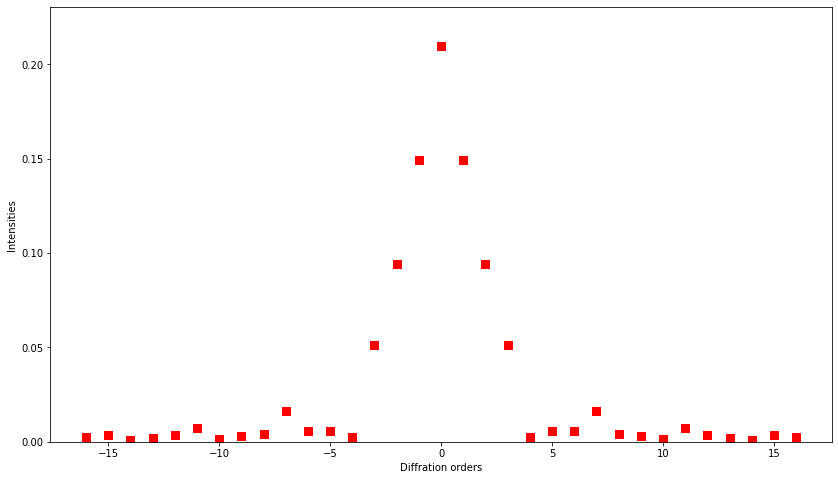

In [20]:
orders_view=np.arange(-16,15)
eff_final = Dammann_efficiencies(orders_view, pos_final, phase_shift=np.pi, has_draw=True)

In [21]:
print(eff_final.sum())
print(eff_final[eff_final>0.0251].sum())

0.911516170267466
0.7978494045775149


In [22]:
eff1 = Dammann_efficiencies(orders, pos_final, phase_shift=np.pi, has_draw=True)

cost1=cost_Dammann1(eff1, effs_desired, normalize=True)

print(cost1)

0.10286509745724703


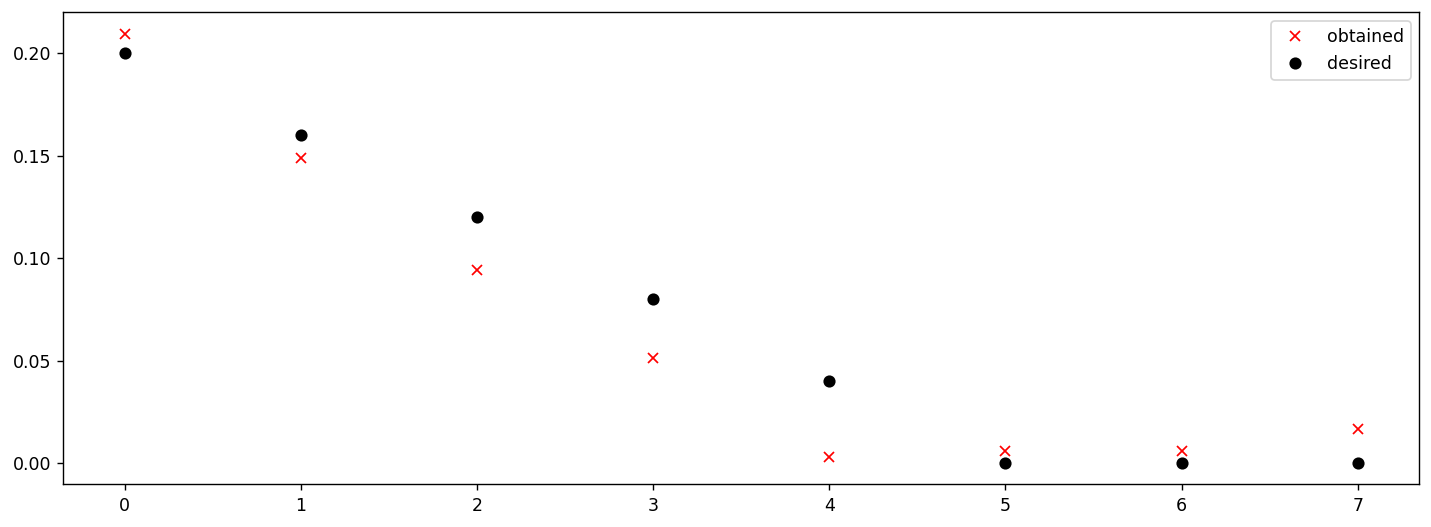

In [32]:
plt.figure(figsize=(14,5))
plt.plot(orders,eff1,'rx', label='obtained')
plt.plot(orders,effs_desired,'ko', label='desired')
plt.legend()

### Si no, ordenamos no funciona

In [24]:
pos_final_sorted=np.sort(pos_final)

In [25]:
eff1 = Dammann_efficiencies(orders, pos_final_sorted, phase_shift=np.pi, has_draw=True)

cost1=cost_Dammann1(eff1, effs_desired, normalize=True)

print(cost1)

0.10286509745724703


# Numérico con diffractio

In [26]:
from diffractio import np,sp,plt
from diffractio import um, nm, mm, degrees
from diffractio.scalar_masks_X import Scalar_mask_X

number of processors: 8
total memory        : 15.5 Gb
available memory    : 72 %
max frequency       : 3100 GHz


In [27]:
x=np.linspace(0,1,1001)
wavelength=0.6328*um

In [28]:
mask=Scalar_mask_X(x,wavelength)
mask.binary_code_positions( pos_final_sorted, 'up', has_draw=False)
mask.draw()

In [29]:
t=np.exp(1j*np.pi*(mask.u-0.5))

t2=np.array(t.tolist()*20)

transformada=np.fft.fft(t2) 
transformada=np.abs(transformada)**2
transformada=transformada/transformada.sum()

far_field=np.fft.fftshift(transformada)

In [30]:
plt.plot(far_field,'k.')
x_med=len(far_field)/2
dx=250
plt.xlim(x_med-dx,x_med+dx,)
plt.ylim(0.001,)

(0.001, 0.21694214876033058)

## Conclusiones
- Hay que meter el sort en el algortimo porque si no no funciona.
- Con el sort dentro del algoritmo, funciona más lento y menos eficiente
- Se pueden meter 0 en los bordes, pero cuesta más
- el número de transiciones tiene que ser par
-  best_cost=0.00416 regular

## Tareas
- Aprender bien PSO y calcular parámetros. ¿cuál es la velocidad?
- Poner límites y evitar transiciones.
- se podrían poner límites de fabricabilidad, es decir si la distancia entre 2 puntos es pequeña, separarla